In [2]:
#!/usr/bin/env python
# coding: utf-8

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sparkify Project Workspace<br>
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.<br>
<br>
You can follow the steps below to guide your data analysis and model building portion of this project.

**install libraries**

In [4]:
# !pip uninstall pyspark
!pip install pyspark==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 204.7 MB 22 kB/s 
     |████████████████████████████████| 198 kB 55.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=a0ffc446ea0b137121ebdcb9b5563edc179697c5bc56b54f06ed1b52c199a303
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


**Import libraries**

In [5]:
# import libraries
from pyspark.sql import SparkSession      
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt
from pyspark.ml.feature import VectorAssembler, StandardScaler\

from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.util import MLUtils

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

**create a Spark session**

In [6]:
# create a Spark session
spark = SparkSession.builder.appName("customer-churn data pipeline").getOrCreate()

# Load and Clean Dataset<br>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
#load json file using .read.json function 
data_path = "/content/drive/MyDrive/new_project/mini_sparkify_event_data.json"
user_event = spark.read.json(data_path)
df = user_event

**Dataset**

In [8]:
#print 1st line of json file.
user_event.show(5)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

**shape of dataset**

In [9]:
print(user_event.count(), len(user_event.columns))

286500 18


**Schema of dataset**

In [10]:
user_event.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



**Count missing values**

In [11]:
#count null values for each column
df_nulls = user_event.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in user_event.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [12]:
# let's make sure page column doesn't have nulls ( as we'll define churn on 'page' column). Do for userId too.
df_nulls.select('userId', 'page').show()

+------+----+
|userId|page|
+------+----+
|     0|   0|
+------+----+



**There are two levels**

In [13]:
user_event.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



**Value counts of level**

In [14]:
level_counts= user_event.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      58338|
| paid|     228162|
+-----+-----------+



**Distint page**

In [15]:
user_event.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



**Value counts of page**

In [16]:
page_counts= user_event.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")
page_counts.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     14457|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       924|
| Submit Registration|         5|
|            Settings|      1514|
|               Login|      3241|
|            Register|        18|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1726|
|             Upgrade|       499|
+--------------------+----------+
only showing top 20 rows



Let's look at **Cancel** and **Cancellation Confirmation** samples in the dataset

In [17]:
cancel_events = user_event.filter(psqf.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_events.show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |1538943740000|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |1539033031000|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancel                   |Mason    |Hart    |1539318918000|Logged In|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



In [18]:
cancel_reg_ids  = [vv['userID'] for vv in cancel_events.select('userID').collect()]
print(len(cancel_reg_ids), len(set(cancel_reg_ids)))

104 52


# Exploratory Data Analysis<br>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.<br>
<br>
### Define Churn<br>
<br>
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.<br>
<br>
### Explore Data<br>
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Define dependent variable**

In [19]:
churn_event = user_event.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
# define 1 as churned, 0 otherwise
churn_f = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_event = churn_event.withColumn("label", churn_f(churn_event.pages)).drop('pages')

In [20]:
churn_event.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
+------+-----+
only showing top 2 rows



**Downgraded customers**

In [21]:
#customer who downgraded
downgrade_events = user_event.filter(psqf.col('page').isin(['Downgrade']))
downgrade_events.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+---------+---------+--------+-------------+---------+
|userID|page     |firstName|lastName|ts           |auth     |
+------+---------+---------+--------+-------------+---------+
|54    |Downgrade|Alexi    |Warren  |1538354749000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538373286000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538392612000|Logged In|
|131   |Downgrade|Kael     |Baker   |1538393618000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538393664000|Logged In|
+------+---------+---------+--------+-------------+---------+
only showing top 5 rows



In [22]:
downgrade_reg_ids = [vv['userID'] for vv in downgrade_events.select('userID').collect()]
print(len(downgrade_reg_ids), len(set(downgrade_reg_ids)))

2055 154


**Downgraded customer cancel their subscription**

In [23]:
# Now let's see which of those who downgraded also cancel thier subscription
down_cancel = set(cancel_reg_ids).intersection((set(downgrade_reg_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(down_cancel))/len(set(downgrade_reg_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


In [24]:
user_event.filter((psqf.col('userID') == list(down_cancel)[0]) &
                  (psqf.col('page').isin(['Downgrade','Cancel']))).select(['userID','page', 'firstName','ts']).show()

+------+---------+---------+-------------+
|userID|     page|firstName|           ts|
+------+---------+---------+-------------+
|100015|Downgrade|     Tina|1539834858000|
|100015|Downgrade|     Tina|1541561504000|
|100015|Downgrade|     Tina|1541561988000|
|100015|Downgrade|     Tina|1543054384000|
|100015|Downgrade|     Tina|1543062503000|
|100015|   Cancel|     Tina|1543073738000|
+------+---------+---------+-------------+



In [25]:
labeled_df  = churn_event.join(user_event, 'userId')

In [26]:
labeled_df.filter(psqf.col('page').isin(["Cancel", "Cancellation Confirmation"])).select('userId', 'page', 'label').show(5)

+------+--------------------+-----+
|userId|                page|label|
+------+--------------------+-----+
|   125|              Cancel|    1|
|   125|Cancellation Conf...|    1|
|    51|              Cancel|    1|
|    51|Cancellation Conf...|    1|
|    54|              Cancel|    1|
+------+--------------------+-----+
only showing top 5 rows



**Value counts of label**

In [27]:
churned_count = labeled_df.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|241636|
|    1| 44864|
+-----+------+



**Songs played users who stayed vs user who churn**

In [28]:
# compare songs played by users who stayed vs user who churn
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("label").agg(psqf.count(psqf.col('song')).alias('SongsPlayed'))
songsplayed.show(5)

+-----+-----------+
|label|SongsPlayed|
+-----+-----------+
|    0|     191714|
|    1|      36394|
+-----+-----------+



**songs liked for users who stayed vs user who churn**

In [29]:
# number of songs liked for users who stayed vs user who churn
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount'))
thumbsup_count.show(5, False)

+-----+-------------+
|label|thumbsUpCount|
+-----+-------------+
|0    |10692        |
|1    |1859         |
+-----+-------------+



**song dislikes for users who stayed vs user who churn**

In [30]:
# number of dislikes for users who stayed vs user who churn
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount'))
thumbsdown_count.show(5)

+-----+---------------+
|label|thumbsDownCount|
+-----+---------------+
|    0|           2050|
|    1|            496|
+-----+---------------+



In [31]:
# number of downgrades for users who stayed vs user who churn
downgrade_count = labeled_df.where((psqf.col("page")=='Downgrade')).groupby("label").agg(psqf.count(psqf.col('page')).alias('downgradeCount'))
downgrade_count.show(5)

+-----+--------------+
|label|downgradeCount|
+-----+--------------+
|    0|          1718|
|    1|           337|
+-----+--------------+



**EDA**

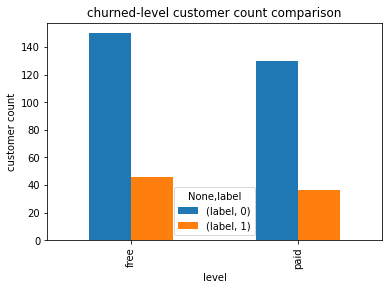

In [32]:
use_level_count = labeled_df.groupby('userId', 'level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'label').toPandas()
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

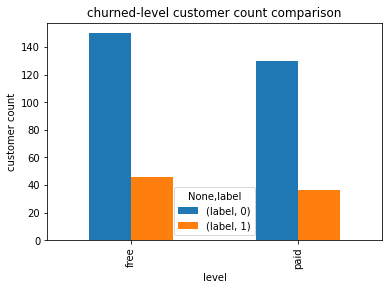

In [33]:
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

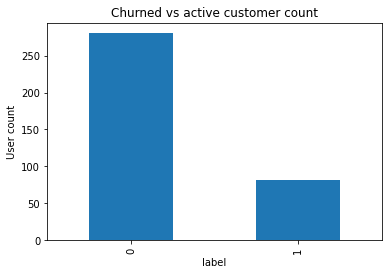

In [34]:
use_level_count_pd.label.value_counts().plot(kind='bar');
plt.ylabel('User count')
plt.xlabel('label')
plt.title('Churned vs active customer count');

# Feature Engineering<br>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.<br>
- Write a script to extract the necessary features from the smaller subset of data<br>
- Ensure that your script is scalable, using the best practices discussed in Lesson 3<br>
- Try your script on the full data set, debugging your script if necessary<br>
<br>
If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

** Number of songs each user played**

In [35]:
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("userId").agg(psqf.count(psqf.col('song')).alias('SongsPlayed')).orderBy('userId')
songsplayed.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



**Number of distinct hour counts  a user logged in the system**

In [36]:
hours_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d-%H'))
hours_df  = labeled_df.select('userId', 'ts').withColumn('hour', hours_udf(psqf.col('ts')))
hours_df.show(5)

+------+-------------+-------------+
|userId|           ts|         hour|
+------+-------------+-------------+
|100010|1539003534000|2018-10-08-12|
|100010|1539003736000|2018-10-08-13|
|100010|1539003932000|2018-10-08-13|
|100010|1539003933000|2018-10-08-13|
|100010|1539004195000|2018-10-08-13|
+------+-------------+-------------+
only showing top 5 rows



In [37]:
hour_count_df = hours_df.where(psqf.col('userId')!='null').groupby('userId').agg((psqf.countDistinct(psqf.col('hour'))).alias("HourCount")).orderBy('userId')
hour_count_df.show(5)

+------+---------+
|userId|HourCount|
+------+---------+
|      |     1306|
|    10|       51|
|   100|      218|
|100001|       14|
|100002|       18|
+------+---------+
only showing top 5 rows



### Thumbs Up and Thumbs Down counts:
A user having a lot of thumbs down could be an indication of the users disastisfaction with song recommendations from Sparkify while a more thumbs up ( likes) by a user indicates user is happy with song recommendations

**Filter rows where user-id is missing**

In [38]:
# filter out rows with userId == null
labeled_df = labeled_df.where(psqf.col('userId')!='null')
labeled_df.show(5)

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|
|100010|    0|Francesca Battist...|Logged In| Darianna|     F|            1|Carpenter|19

In [39]:
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up') &(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount')).orderBy('userId')
thumbsup_count.show(5, False)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|10    |37           |
|100   |148          |
|100001|8            |
|100002|5            |
|100003|3            |
+------+-------------+
only showing top 5 rows



In [40]:
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')&(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount')).orderBy('userId')
thumbsdown_count.show(5)

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|    10|              4|
|   100|             27|
|100001|              2|
|100004|             11|
|100005|              3|
+------+---------------+
only showing top 5 rows



**Merge all features by vector assembler**

In [41]:
## Join all the features
features_df = churn_event.join(songsplayed, "userId").\
join(hour_count_df, "userId").join(thumbsup_count, "userId").join(thumbsdown_count, "userId")

In [42]:
features_df.show(5)

+------+-----+-----------+---------+-------------+---------------+
|userId|label|SongsPlayed|HourCount|thumbsUpCount|thumbsDownCount|
+------+-----+-----------+---------+-------------+---------------+
|100010|    0|        275|       26|           17|              5|
|200002|    0|        387|       32|           21|              6|
|   124|    0|       4079|      306|          171|             41|
|    51|    1|       2111|      156|          100|             21|
|     7|    0|        150|       18|            7|              1|
+------+-----+-----------+---------+-------------+---------------+
only showing top 5 rows



In [43]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "HourCount", "thumbsUpCount", "thumbsDownCount"], outputCol="rawFeatures")
features_df = assembler.transform(features_df)
features_df.select('label', 'rawFeatures').show(4)

+-----+--------------------+
|label|         rawFeatures|
+-----+--------------------+
|    0|[275.0,26.0,17.0,...|
|    0|[387.0,32.0,21.0,...|
|    0|[4079.0,306.0,171...|
|    1|[2111.0,156.0,100...|
+-----+--------------------+
only showing top 4 rows



**Feature scaling**

In [44]:
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [45]:
input_data = features_df.withColumn('label', psqf.col('label').cast(psqt.IntegerType())).select('label', 'features')
input_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639992057147...|
|    0|[0.34675188822240...|
+-----+--------------------+
only showing top 2 rows



# Modeling<br>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**Handle categorical features using string indexer**

In [46]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [47]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

**Train test spliting**

In [48]:
# Split the data into training and test sets (since dataset is imbalanced)
(trainingData, tempData) = input_data.randomSplit([0.6, 0.4])
(validationData, testData) = tempData.randomSplit([0.5, 0.5])

**Random Forest**

In [49]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [50]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

**Prediction on unseen data**

In [51]:
# Make predictions.
predictions = model.transform(validationData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.73471976315859...|
|             0|    0|[1.72748744313385...|
|             0|    1|[1.61011148097071...|
|             0|    1|[0.20607993356887...|
|             0|    0|[1.26963159072649...|
+--------------+-----+--------------------+
only showing top 5 rows

Validation Error = 0.205128
RandomForestClassificationModel: uid=RandomForestClassifier_d831dc554619, numTrees=10, numClasses=2, numFeatures=4


**Evaluate the performance**

In [52]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.760531


**Hyperparameter tunning of random forest**

In [53]:
rfc = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rfc, labelConverter])
param_grid = ParamGridBuilder().addGrid(rfc.numTrees, [10, 15]).addGrid(rfc.maxDepth, [2, 5]).build()
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)

best_model = cv.fit(trainingData)

**Evaluate performance of optimized model**

In [54]:
def evaluate_model(model, data):
    """
    Make prediction and evaluate model.
    Parameters
    -----------
        model: model object
    returns
    -------
        None
    """
    predictions = model.transform(data)

    # Select example rows to display.
    predictions.select("predictedLabel", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Error = %g" % (1.0 - accuracy))
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
    f1_score = f1_score_evaluator.evaluate(predictions)
    print("F1 score = %g" % (f1_score))

In [55]:
evaluate_model(model=best_model, data=validationData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.73471976315859...|
|             0|    0|[1.72748744313385...|
|             0|    1|[1.61011148097071...|
|             0|    1|[0.20607993356887...|
|             0|    0|[1.26963159072649...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.205128
F1 score = 0.760531


In [56]:
evaluate_model(model=best_model, data=testData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.13439995667535...|
|             0|    1|[2.54553517943116...|
|             0|    0|[3.20140696800688...|
|             0|    1|[0.19174393819016...|
|             0|    0|[0.58239981225985...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.351351
F1 score = 0.568878


# Results
We have analysed the sparkify dataset and come up with new features to predict churn. We then created a machine learning model and tuned it to improve its performance. We achieved an accuracy score of - and F1 score of - on the test dataset. 

# Conclusion
We are able to achieve an accuracy score of -- and F1 score of -- on the test dataset using the tuned Random Forest algorithm. The model peformance can be further improved by creating additional features and includiding some of the features that I have left out for this analysis. The model should also be tested using samples from the left out big dataset which hasn't been used for this analysis. Once we are satified with the result, a large scale of the model can be implemented on the cloud.

# Final Steps<br>
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

**Load the dataset**

In [90]:
data = spark.read.json(data_path)
df = data

**Dataset**

In [91]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

**shape of dataset**

In [92]:
print(df.count(), len(df.columns))

286500 18


**Schema of dataset**

In [93]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



**Count missing values**

In [94]:
#count null values for each column
df_nulls = df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in user_event.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [95]:
# let's make sure page column doesn't have nulls ( as we'll define churn on 'page' column). Do for userId too.
df_nulls.select('userId', 'page').show()

+------+----+
|userId|page|
+------+----+
|     0|   0|
+------+----+



**Levels**

In [96]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



**Value counts of level**

In [97]:
level_counts= df.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      58338|
| paid|     228162|
+-----+-----------+



**Distint value of  page**

In [98]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [99]:
churn_event = df.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
# define 1 as churned, 0 otherwise
churn_f = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_event = churn_event.withColumn("label", churn_f(churn_event.pages)).drop('pages')

In [100]:
churn_event.show(2)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
+------+-----+
only showing top 2 rows



**Exploratory Data Analysis**

**count comparison of customers churned-level**

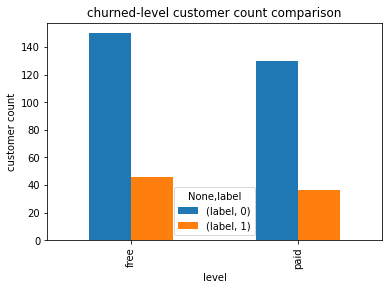

In [68]:
use_level_count = labeled_df.groupby('userId', 'level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'label').toPandas()
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

**Churned vs active customer count**

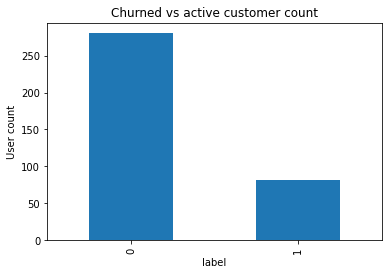

In [70]:
use_level_count_pd.label.value_counts().plot(kind='bar');
plt.ylabel('User count')
plt.xlabel('label')
plt.title('Churned vs active customer count');

**Label distribution**

In [71]:
labeled_df.groupBy('userId','label','gender').count().select('label', 'gender').groupBy('label','gender').count().show()

+-----+------+-----+
|label|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|  null|    1|
|    1|     M|   32|
|    0|     F|   84|
|    1|     F|   20|
+-----+------+-----+



**Number of songs each user played**

In [72]:
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("userId").agg(psqf.count(psqf.col('song')).alias('SongsPlayed')).orderBy('userId')
songsplayed.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



**Number of distinct hour counts  a user logged in the system**

In [73]:
hours_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d-%H'))
hours_df  = labeled_df.select('userId', 'ts').withColumn('hour', hours_udf(psqf.col('ts')))
hours_df.show(5)

+------+-------------+-------------+
|userId|           ts|         hour|
+------+-------------+-------------+
|100010|1539003534000|2018-10-08-12|
|100010|1539003736000|2018-10-08-13|
|100010|1539003932000|2018-10-08-13|
|100010|1539003933000|2018-10-08-13|
|100010|1539004195000|2018-10-08-13|
+------+-------------+-------------+
only showing top 5 rows



In [74]:
hour_count_df = hours_df.where(psqf.col('userId')!='null').groupby('userId').agg((psqf.countDistinct(psqf.col('hour'))).alias("HourCount")).orderBy('userId')
hour_count_df.show(5)

+------+---------+
|userId|HourCount|
+------+---------+
|      |     1306|
|    10|       51|
|   100|      218|
|100001|       14|
|100002|       18|
+------+---------+
only showing top 5 rows



**Filter rows where user-id is missing**

In [75]:
# filter out rows with userId == null
labeled_df = labeled_df.where(psqf.col('userId')!='null')
labeled_df.show(5)

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|
|100010|    0|Francesca Battist...|Logged In| Darianna|     F|            1|Carpenter|19

In [76]:
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up') &(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount')).orderBy('userId')
thumbsup_count.show(5, False)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|10    |37           |
|100   |148          |
|100001|8            |
|100002|5            |
|100003|3            |
+------+-------------+
only showing top 5 rows



In [77]:
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')&(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount')).orderBy('userId')
thumbsdown_count.show(5)

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|    10|              4|
|   100|             27|
|100001|              2|
|100004|             11|
|100005|              3|
+------+---------------+
only showing top 5 rows



# **Feature engineering**

**Merge all features using vector assembler**

In [78]:
## Join all the features
features_df = churn_event.join(songsplayed, "userId").\
join(hour_count_df, "userId").join(thumbsup_count, "userId").join(thumbsdown_count, "userId")

In [79]:
features_df.show(5)

+------+-----+-----------+---------+-------------+---------------+
|userId|label|SongsPlayed|HourCount|thumbsUpCount|thumbsDownCount|
+------+-----+-----------+---------+-------------+---------------+
|100010|    0|        275|       26|           17|              5|
|200002|    0|        387|       32|           21|              6|
|   124|    0|       4079|      306|          171|             41|
|    51|    1|       2111|      156|          100|             21|
|     7|    0|        150|       18|            7|              1|
+------+-----+-----------+---------+-------------+---------------+
only showing top 5 rows



**Vector Assembler**

In [80]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "HourCount", "thumbsUpCount", "thumbsDownCount"], outputCol="rawFeatures")
features_df = assembler.transform(features_df)
features_df.select('label', 'rawFeatures').show(4)

+-----+--------------------+
|label|         rawFeatures|
+-----+--------------------+
|    0|[275.0,26.0,17.0,...|
|    0|[387.0,32.0,21.0,...|
|    0|[4079.0,306.0,171...|
|    1|[2111.0,156.0,100...|
+-----+--------------------+
only showing top 4 rows



**Feature scaling**

In [81]:
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [82]:
input_data = features_df.withColumn('label', psqf.col('label').cast(psqt.IntegerType())).select('label', 'features')
input_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639992057147...|
|    0|[0.34675188822240...|
+-----+--------------------+
only showing top 2 rows



**Handle categorical features**

In [83]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [84]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

#**Modeling**

**Train test splitting**

In [85]:
# Split the data into training and test sets (since dataset is imbalanced)
(trainingData, tempData) = input_data.randomSplit([0.6, 0.4])
(validationData, testData) = tempData.randomSplit([0.5, 0.5])

**Random Forest**

In [86]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

**Training  of Random Forest**

In [87]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

**Prediction of random forest**

In [88]:
# Make predictions.
predictions = model.transform(validationData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    1|[1.89145539027778...|
|             0|    0|[1.85471940211985...|
|             0|    1|[2.71308712541977...|
|             0|    1|[0.19174393819016...|
|             0|    0|[1.42015954220288...|
+--------------+-----+--------------------+
only showing top 5 rows

Validation Error = 0.27907
RandomForestClassificationModel: uid=RandomForestClassifier_15307a79be29, numTrees=10, numClasses=2, numFeatures=4


**Evaluate the performance of Random Forest**

In [89]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.672757
